<a href="https://colab.research.google.com/github/Burningzabidan/kims_bearing/blob/main/%5B%E1%84%87%E1%85%A6%E1%84%8B%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6%5D%E1%84%80%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A9_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
from torchvision import transforms

import os
import cv2
from PIL import Image
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1.인장 시험 데이터 가져오기 및 데이터 정리


In [138]:
def load_property(target:str) -> list:
    """
    인장 시험 텍스트 파일 불러와 리스트화
    target = "tensile strength" or "yield strength" or "elongation"
    """

    loc = f"./properties/{target}.txt"
    f = open(loc,"r")
    lines = f.readlines()
    lines = [re.sub('[\n| ]', '', line) for line in lines] # 공백, \n 제거

    return lines


def make_pd(lines:list) -> pd.DataFrame:
    """
    불러온 물성 텍스트 파일 리스트 df화
    column = 샘플 번호, 샘플 서브 번호, 물성
    """

    no = [int(i[0]) for i in lines if i[0].isnumeric() and '-' in i] # 샘플 번호만 추출
    sub_no = [int(i[2]) for i in lines if i[0].isnumeric() and '-' in i] 
    properties = [int(i) for i in lines if i.isnumeric()] # 물성만 추출

    df = pd.DataFrame({"no":no, "sub_no": sub_no, "properties":properties})

    return df


lines = load_property("tensile_strength")
df = make_pd(lines)

print(df.head(20)) # check the first 10 columns

    no  sub_no  properties
0    1       1        1527
1    1       2        1439
2    1       3        1445
3    1       4        1421
4    1       5        1429
5    2       1        1200
6    2       2        1225
7    2       3        1256
8    2       4        1211
9    2       5        1253
10   3       1        1096
11   3       2        1110
12   3       3        1096
13   3       4        1092
14   3       5        1177
15   4       1        1004
16   4       2        1004
17   4       3        1033
18   4       4        1019
19   4       5         994


In [139]:
def get_linked_prop(df:pd.DataFrame) -> dict:
  """
  df로 정리된 인장 시험 결과를 샘플 시리즈를 keyword로,
  물성 별 측정값을 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  dic = {}
  for i in range(1,6):
    dic[i] = []

  # df로부터 시리즈별 물성을 연결 리스트에 저장
  for i in range(len(df)):
      dic[df["no"][i]].append(df["properties"][i])

  return dic

properties = get_linked_prop(df)

# check the dic
print(properties)

{1: [1527, 1439, 1445, 1421, 1429], 2: [1200, 1225, 1256, 1211, 1253], 3: [1096, 1110, 1096, 1092, 1177], 4: [1004, 1004, 1033, 1019, 994], 5: [896, 882, 918, 897, 928]}


# 2.이미지 데이터 가져오기 및 정리


dict_keys([1, 2, 3, 4, 5])


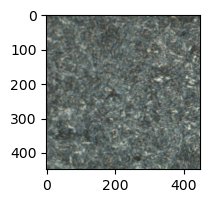

In [140]:
### 연결 리스트로 샘플 시리즈별 이미지 정리

def get_lined_img(img_size:int, step_size:int) -> dict:
  """
  이미지를 불러와서 샘플 시리즈를 keyword,
  이미지를 value로 갖는 딕셔너리를 반환함
  """
  
  # 빈 연결 리스트 생성
  imgs = {}
  for i in range(1,6):
    imgs[i] = []

  # 이미지를 크롭하여 시리즈별로 연결 리스트에 저장
  loc = "./images/"
  files = [f for f in os.listdir(loc) if "tif" in f]
  for file in files:
    img = (cv2.imread(loc + file)/255).astype(np.float32)
    h,w,c = img.shape
    for dx in range(0,h-img_size,step_size): 
      for dy in range(0,w-img_size,step_size):
        img_crop = img[dx:dx+img_size,dy:dy+img_size]
        series = int(file[0])
        imgs[series].append(img_crop)

  return imgs

imgs = get_lined_img(img_size = 448, step_size = 56)

# check the result
print(imgs.keys())
plt.figure(figsize = (2,2)) 
plt.imshow(imgs[1][0]) # plot example

# 3. 이미지 별 물성 생성


In [141]:
def gen_properties(imgs:dict, properties:dict) -> np.array:
  """
  이미지가 해당 시리즈의 물성의 최대 최소 값 사이의 값을 가지도록
  물성 값을 랜덤하게 생성후 할당
  """
  # 빈 연결 리스트 생성
  gen_properties = {}
  for i in range(1,6):
    gen_properties[i] = []

  # 난수 시드 고정
  np.random.seed(0)

  # 생선된 물성 (gen_propertieserated) 연결 리스트에 저장
  for i in range(1,6):
      n_min = min(properties[i])
      n_max = max(properties[i])
      n_imgs = len(imgs[i])
      for _ in range(n_imgs):
        prop_gen = random.choice(range(n_min, n_max+1))
        gen_properties[i].append(prop_gen)
  
  return gen_properties

generated_properties = gen_properties(imgs, properties)
stacked_properties = np.concatenate(list(generated_properties.values()), dtype = np.float32) # dict to 1d array
stacked_properties_norm = (stacked_properties-min(stacked_properties))/ (max(stacked_properties)-min(stacked_properties))  # 최소값을 0, 최대값을 1로
print(f"len, min, max of stacked_properties: {len(stacked_properties_norm),min(stacked_properties_norm),max(stacked_properties_norm)}")

def stack_imgs(imgs:dict) -> np.array:
  """
  샘플별 이미지 딕셔너리를 1d array로 변환
  """
  n = sum([len(imgs[i]) for i in imgs])   # 이미지 총 갯수
  
  # 이미지 차원 구하기
  h,w,c = imgs[1][0].shape # 1번째 시리즈의 1번째 이미지
  # 빈 이미지 변수 생성 -> 미리 만들어주는게 효율적
  imgs_stack = np.empty((n,h,w,c), dtype = np.float32)

  # 이미지 쌓기
  idx = 0
  for i in imgs:
    for img in imgs[i]:
      imgs_stack[idx] = img
      idx += 1
  return imgs_stack

stacked_imgs = stack_imgs(imgs)

# check the input and output
X = stacked_imgs
y = stacked_properties_norm

print(f"type of X:{type(X)}, type of y:{type(y)}")
print(f"shape of X:{X.shape}, shape of y:{y.shape}")
print(f"dtype of X:{X.dtype}, dtype of y:{y.dtype}")

len, min, max of stacked_properties: (600, 0.0, 1.0)
type of X:<class 'numpy.ndarray'>, type of y:<class 'numpy.ndarray'>
shape of X:(600, 448, 448, 3), shape of y:(600,)
dtype of X:float32, dtype of y:float32


# 4. 데이터 전처리

In [142]:
# 훈련 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 0)
print(f"shape of X_train:{X_train.shape}")
print(f"shape of X_test:{X_test.shape}")
print(f"shape of y_train:{y_train.shape}")
print(f"shape of y_test:{y_test.shape}")
print("-"*50)

# 이미지 데이터  변환
img_transformer = transforms.Compose([
        transforms.ToTensor(), # 텐서화
        transforms.Normalize(  # 정규화
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225],
            ),
        ])

# 이미지 데이터 클래스 정의
class img_dataset(Dataset):
  def __init__(self,x,y,transform):
    self.x = x
    self.y = y
    self.T = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.T(self.x[idx]), self.y[idx]

# 데이터로더에 훈련데이터 격납
train_dataset = img_dataset(X_train, y_train, img_transformer)
test_dataset = img_dataset(X_test, y_test, img_transformer)
train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = True)

# 결과 확인
# tmp = list(iter(train_loader))
# print(f"shape of train batch imgs:{tmp[0][0].shape}")
# print(f"shape of train batch labels:{tmp[0][1].shape}")
# plt.figure(figsize = (4,4))
# plt.imshow(tmp[0][0][0].permute(1,2,0)) # 1st img of the batch

shape of X_train:(540, 448, 448, 3)
shape of X_test:(60, 448, 448, 3)
shape of y_train:(540,)
shape of y_test:(60,)
--------------------------------------------------


# 5. 모델링

In [145]:
# loading resnet101
my_model = models.resnet101(pretrained = True)

# change in and out features of fc layer
in_features = my_model.fc.in_features
out_features = 1
my_model.fc = nn.Linear(in_features, out_features)

# freeze parameters when training
for params in my_model.parameters():
  params.requires_grad = True

# unfreeze parameters of fc layer when training
for params in my_model.fc.parameters():
  params.requires_grad = True

# model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device={device}")
my_model.to(device)

/Users/hoheokkim/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hoheokkim/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device=cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 6. 모델 훈련

In [ ]:
# 파라미터 설정
n_epoch = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(my_model.parameters(), lr = 0.00001)

train_loss_lst = []
test_loss_lst = []

for i in range(n_epoch):
  for j,[x,y] in enumerate(train_loader):
    x = x.to(device)
    y = y.unsqueeze(1).to(device)

    optimizer.zero_grad()
    y_pred = my_model(x)
    loss = criterion(y,y_pred)
    loss.backward()
    optimizer.step()

    train_loss_lst.append(loss.item())


    with torch.no_grad():
      test_loss = 0
      n = 0
      for k, [x_test, y_test] in enumerate(test_loader):
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_test_pred = my_model(x_test)
        loss_test = criterion(y_test, y_test_pred)
        test_loss += loss_test.item()
        n+=1
    test_loss /= n
    test_loss_lst.append(test_loss)

    # 훈련 진행 상황 출력
    print(f"i:{i}    j:{j}    train_loss:{loss.item():.4f}    test_loss:{test_loss:.3f}    y_test:{y_test[0].item():.3f}    y_test_pred:{y_test_pred[0].item():.3f}")

    # 모델 저장
    if i >= 1 and loss.item() == min(train_loss_lst):
      print("train model saved")
      torch.save(my_model.state_dict(), "train_best_model.pth")

    if i >= 1  and test_loss == min(test_loss_lst):
      print("val model saved")
      torch.save(my_model.state_dict(), "test_best_model.pth")

    torch.save(my_model.state_dict(), "last_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


i:0    j:0    train_loss:0.5126    val_loss:0.413    y_val:0.228    y_val_pred:-0.337
i:0    j:1    train_loss:0.3907    val_loss:0.410    y_val:0.322    y_val_pred:-0.392
i:0    j:2    train_loss:0.6419    val_loss:0.416    y_val:0.228    y_val_pred:-0.184
i:0    j:3    train_loss:0.3404    val_loss:0.446    y_val:0.855    y_val_pred:-0.204
i:0    j:4    train_loss:0.3999    val_loss:0.396    y_val:0.260    y_val_pred:-0.153
i:0    j:5    train_loss:0.2799    val_loss:0.428    y_val:0.915    y_val_pred:0.247
i:0    j:6    train_loss:0.4555    val_loss:0.406    y_val:0.056    y_val_pred:-0.491
i:0    j:7    train_loss:0.3492    val_loss:0.368    y_val:0.260    y_val_pred:0.111
i:0    j:8    train_loss:0.6081    val_loss:0.368    y_val:0.056    y_val_pred:-0.659
i:0    j:9    train_loss:0.2268    val_loss:0.386    y_val:0.056    y_val_pred:-0.523
i:0    j:10    train_loss:0.4862    val_loss:0.408    y_val:0.228    y_val_pred:-0.327
i:0    j:11    train_loss:0.4486    val_loss:0.360    y

# 7. 훈련 결과 플롯

In [146]:
def predict(model, dataloader:DataLoader, pretrained:str = None)-> list:
    """
    pretrained 모델 있으면 로드하여 예측을 진행, 없으면 모델 그대로 예측을 진행
    라벨(y) 및 예측 (y_pred)를 리스트로 반환
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if pretrained != None:
        model.load_state_dict(torch.load(pretrained, "cuda"))
    model = nn.DataParallel(model) # 멀티 GPU 사용
    model.to(device)

    y_lst = []
    y_pred_lst = []

    for i,j in dataloader:
        j = j.tolist()
        y_lst.extend(j)
        y_pred = model(i.to(device))
        y_pred = y_pred.squeeze(1).to("cpu").tolist() # GPU 메모리 절약 위해
        y_pred_lst.extend(y_pred)

    return y_lst, y_pred_lst

def denormalize(lst:list) -> list:
    """
    정규화된 물성 리스트를 받아 비정규화된 물성 리스트를 반환
    """
    n_min = min(stacked_properties)
    n_max = max(stacked_properties)

    res = []
    for i in lst:
        res.append((n_max-n_min)*i + n_min)
    return res

def get_rmse(x:list,y:list) -> float:
    """
    Root means square error (RMSE) 계산하여 반환
    """
    rmse = np.array(x)- np.array(y)
    rmse = np.square(rmse).sum()/len(x)
    rmse = np.power(rmse,0.5)
    return rmse

In [149]:
y_lst, y_pred_lst = predict(my_model.to(device), train_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "train")
print(f"train_rsme:{get_rmse(y_lst,y_pred_lst)}")

y_lst, y_pred_lst = get_pred(my_model.to(device), test_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "test")
print(f"test_rsme:{get_rmse(y_lst,y_pred_lst)}")

plt.legend()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.